In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import random
import os
from sklearn.preprocessing import MinMaxScaler
import sys
import matplotlib.pyplot as plt

In [2]:
# Hinged Square Loss
class SquaredHingeLoss(nn.Module):
    def __init__(self, margin=0):
        super(SquaredHingeLoss, self).__init__()
        self.margin = margin

    def forward(self, predicted, y):
        low, high = y[:, 0:1], y[:, 1:2]
        loss_low = torch.relu(low - predicted + self.margin)
        loss_high = torch.relu(predicted - high + self.margin)
        loss = loss_low + loss_high
        return torch.mean(torch.square(loss))

In [3]:
# MLP models
class MLP(nn.Module):
    def __init__(self, input_size, layer_sizes):
        super(MLP, self).__init__()
        layers = []
        prev_size = input_size

        # Create hidden layers
        for size in layer_sizes:
            layers.append(nn.Linear(prev_size, size))
            layers.append(nn.Sigmoid())
            prev_size = size

        # Add output layer
        layers.append(nn.Linear(prev_size, 1))  # Output layer

        self.model = nn.Sequential(*layers)  # Combine layers into a sequential model

    def forward(self, x):
        return self.model(x)

In [4]:
dataset = 'simulated.abs'

In [5]:
target_df = pd.read_csv(f'../data/{dataset}/targets.csv')
features_df = pd.read_csv(f'../data/{dataset}/features.csv')

In [6]:
# split data into training and testing
X = features_df.values[:,0].reshape(-1, 1)
y = target_df.values

# normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# split 70% training and 30% testing
train_size = int(0.7 * len(X))
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# convert them to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [7]:
model = MLP(input_size=X_train.shape[1], layer_sizes=[4])
optimizer = torch.optim.Adam(model.parameters())
criterion = SquaredHingeLoss()

# Early stopping parameters
patience = 100  # Number of epochs to wait for an improvement in loss before stopping
delta = 1e-8  # Minimum change in loss for it to be considered an improvement
best_loss = float('inf')  # Initialize the best loss to a very large number
epochs_without_improvement = 0  # Counter for epochs without improvement

for epoch in range(20000):
    # Training step
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Check if the loss improvement is greater than the delta
    if best_loss - loss.item() > delta:
        best_loss = loss.item()
        epochs_without_improvement = 0  # Reset counter if loss improves
    else:
        epochs_without_improvement += 1
    if epoch % 2000 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item()}")
    # Early stopping condition: stop if no significant improvement for `patience` epochs
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1: Loss = 4.075530529022217
Epoch 2001: Loss = 1.0504249334335327
Epoch 4001: Loss = 1.0433164834976196
Epoch 6001: Loss = 1.0430798530578613
Epoch 8001: Loss = 0.9715443253517151
Epoch 10001: Loss = 0.3014191687107086
Epoch 12001: Loss = 0.01916629634797573
Epoch 14001: Loss = 0.0018178271129727364
Epoch 16001: Loss = 0.0004599819367285818
Epoch 18001: Loss = 0.0003840550489258021


In [8]:
# get prediction from X_test
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

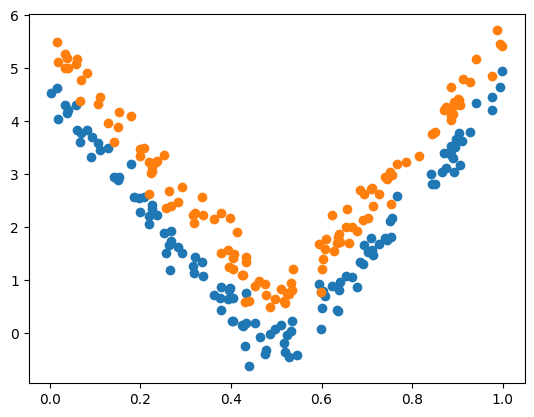

In [9]:
# using matplotlib to scatter plot y_pred and X_test
plt.scatter(X_train[:,0], y_train[:,0])
plt.scatter(X_train[:,0], y_train[:,1])

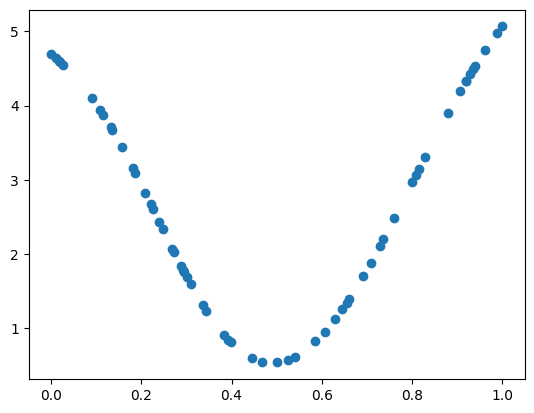

In [10]:
plt.scatter(X_test[:,0], y_pred)

In [11]:
# print the test loss
loss = criterion(y_pred, y_test)
print(f"Test Loss: {loss.item()}")

Test Loss: 0.0020137864630669355
